# Data Preprocessing

## Crime(보이스피싱) Data

In [4]:
# package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from tqdm import tqdm

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

In [93]:
# csv load(7.1s)
KP2020 = pd.read_csv('data/KP2020.csv', encoding='cp949')
KP2021 = pd.read_csv('data/KP2021.csv', encoding='cp949')
NPA2020 = pd.read_csv('data/NPA2020.csv', encoding='cp949')

### 보이스피싱 범죄 Dataset Generate
- 사건코드 : EVT_CL_CD == 215 </br>
- 동일사건 제외 : SME_EVT_YN != Y

In [94]:
KP2020 = KP2020.loc[(KP2020.EVT_CL_CD == 215) & (KP2020.SME_EVT_YN != 'Y'),:]
KP2021 = KP2021.loc[(KP2021.EVT_CL_CD == 215) & (KP2021.SME_EVT_YN != 'Y'),:]
NPA2020 = NPA2020.loc[(NPA2020.EVT_CL_CD == 215) & (NPA2020.SME_EVT_YN != 'Y'),:]

In [95]:
# Datetime 통일
NPA2020['RECV_CPLT_DM'] = None
NPA2020['RECV_CPLT_DM'] = NPA2020['RECV_CPLT_DM'].astype('str')
NPA2020['RECV_CPLT_DT'] = NPA2020['RECV_CPLT_DT'].astype('str')
NPA2020['RECV_CPLT_TM'] = NPA2020['RECV_CPLT_TM'].astype('str')

NPA2020['RECV_CPLT_DM'] = [i + j.zfill(6) for i,j in NPA2020[['RECV_CPLT_DT','RECV_CPLT_TM']].values] # 시간 6자리로 코딩 후 병합
NPA2020 = NPA2020[NPA2020.columns.drop(['RECV_CPLT_DT','RECV_CPLT_TM'])]

In [96]:
KP2020['RECV_CPLT_DM'] = pd.to_datetime(KP2020['RECV_CPLT_DM'], yearfirst=True)
KP2021['RECV_CPLT_DM'] = pd.to_datetime(KP2021['RECV_CPLT_DM'], yearfirst=True)
NPA2020['RECV_CPLT_DM'] = pd.to_datetime(NPA2020['RECV_CPLT_DM'], yearfirst=True)

In [97]:
# 사용컬럼만 추출
cols = ['RECV_CPLT_DM', 'NPA_CL', 'RPTER_SEX', 'HPPN_X', 'HPPN_Y']
KP2020 = KP2020[cols]
KP2021 = KP2021[cols]
NPA2020 = NPA2020[cols]

In [98]:
# Merge
df_crime = pd.concat([KP2020, KP2021, NPA2020], axis=0).dropna(axis=0).sort_values(by='RECV_CPLT_DM')
df_crime = df_crime[~(df_crime.HPPN_X == 0)].reset_index(drop=True)

# to GeoDataFrame
gdf_crime = gpd.GeoDataFrame(df_crime, geometry=gpd.points_from_xy(df_crime['HPPN_X'], df_crime['HPPN_Y']), crs='WGS84')
gdf_crime = gdf_crime[gdf_crime.columns.drop(['HPPN_X','HPPN_Y'])]

In [99]:
gdf_crime = gdf_crime.loc[gdf_crime.NPA_CL.isin([19,13,31]),:] # 충남, 세종, 대전 한정 데이터 추출
gdf_crime.to_file('data/gdf_crime.gpkg')

## Geographic Processing

In [190]:
gdf_crime = gpd.read_file('data/gdf_crime.gpkg')

In [191]:
# 행정구역 data
sejong = gpd.read_file('data/ADM_AREA/세종/LSMD_ADM_SECT_UMD_36.shp', encoding='cp949')
sejong = sejong.to_crs('WGS84')
sejong['시도'] = '세종'

daejeon = gpd.read_file('data/ADM_AREA/대전/LSMD_ADM_SECT_UMD_30.shp', encoding='cp949')
daejeon = daejeon.to_crs('WGS84')
daejeon['시도'] = '대전'

chungnam = gpd.read_file('data/ADM_AREA/충남/LSMD_ADM_SECT_UMD_44.shp', encoding='cp949')
chungnam = chungnam.to_crs('WGS84')
chungnam['시도'] = '충남'
chungnam.total_bounds

array([125.540788  ,  35.97826354, 127.63974798,  37.06475374])

In [192]:
# 충남지역은 도서지역이 포함되므로 육지(태안군 소원면까지를 왼쪽 기준으로 잡음)만 행정구역으로 사용
from shapely.geometry import MultiPolygon
from operator import itemgetter

소원면 = chungnam.loc[chungnam.EMD_NM == '소원면','geometry']
xmin, _, _, _ = 소원면.total_bounds
dropls = []
for i,g_i in enumerate(tqdm(chungnam.geometry)):
    if type(g_i) == MultiPolygon:
        keep_i = list(range(len(g_i.geoms)))
        for j, g_j in enumerate(g_i.geoms):
            if g_j.bounds[0] < xmin:
                keep_i.remove(j)
        
        chungnam.geometry[i] = MultiPolygon(list(itemgetter(*keep_i)(g_i.geoms)))
    else:
        if g_i.bounds[0] < xmin:
            dropls.append(i)

chungnam.total_bounds

100%|██████████| 289/289 [00:00<00:00, 5400.36it/s]


array([126.09263811,  35.97826354, 127.63974798,  37.06475374])

In [193]:
whole_area = pd.concat([sejong, daejeon, chungnam], axis=0)
whole_area.to_file('data/whole_adm_area.gpkg', index=False)

### Griding

In [194]:
# 격자생성
'''
지역과 intersect되는 격자 추출
'''
from shapely.geometry import Polygon

whole_area_5181 = whole_area.to_crs(epsg=5181)
xmin, ymin, xmax, ymax = whole_area_5181.total_bounds # Total bound : 최대지점

length = 1000 # 가로/세로 500m 격자
wide = 1000

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

polygons = []
for x in tqdm(cols[:-1]):
    for y in rows[:-1]:
        polygon_i = Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)])
        if whole_area_5181.geometry.intersects(polygon_i).any(): # Intersect(교차) 여부 파악
            polygons.append(polygon_i)
        else:
            pass

grid = gpd.GeoDataFrame({'geometry':polygons}, crs='EPSG:5181').to_crs('WGS84')
grid.to_file('data/grid.gpkg', index=False)
print('격자개수 : ' + str(len(grid)))

100%|██████████| 139/139 [00:18<00:00,  7.65it/s]


격자개수 : 10028


In [195]:
# 각 접수사건 포함 행정구역 추출
from tqdm import tqdm

gdf_crime['ADM_AREA'] = 0 # 충남/세종/대전 지역 외 발생사건은 행정구역 0으로 표기
for i in tqdm(range(len(gdf_crime))):
    arr_i = np.where(whole_area.geometry.intersects(gdf_crime.geometry[i]))[0]
    if len(arr_i) > 0 :
        gdf_crime.iat[i, 4] = whole_area.iat[arr_i[0],4] # GID 대입

100%|██████████| 33926/33926 [00:43<00:00, 782.97it/s]


In [196]:
# 대상지역 외 사건 제외(590개)
gdf_crime = gdf_crime[~(gdf_crime.ADM_AREA == 0)]

In [197]:
# 각 지역별로 분리
gdf_crime_chungnam = gdf_crime.loc[gdf_crime.ADM_AREA.isin(chungnam.GID),:]
gdf_crime_daejeon = gdf_crime.loc[gdf_crime.ADM_AREA.isin(daejeon.GID),:]
gdf_crime_sejong = gdf_crime.loc[gdf_crime.ADM_AREA.isin(sejong.GID),:]

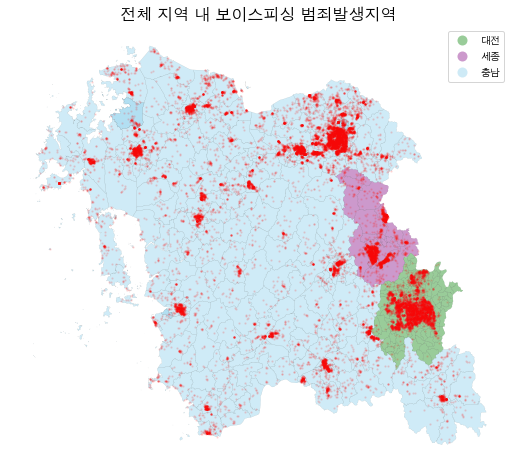

In [210]:
# Plot
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
whole_area.plot(column='시도', ax=ax, zorder=1, cmap=ListedColormap(['green','purple','skyblue']), alpha=0.4, edgecolor='black', linewidth=0.1, legend=True, categorical=True)
gdf_crime.geometry.plot(ax=ax, zorder=2, color='red', alpha=0.1, markersize=2)

ax.set_axis_off()

plt.title('전체 지역 내 보이스피싱 범죄발생지역', fontsize=16)
plt.savefig('plot/전체 지역 내 보이스피싱 범죄발생지역.png', facecolor = 'white')
plt.show()

In [211]:
gdf_crime.to_file('data/gdf_crime_adm.gpkg', index=False)

## 외부데이터 처리

### ATM/은행 등 현금인출기 위치정보 처리
- Geocoding

In [2]:
geo_local = Nominatim(user_agent='South Korea') # 지오코더
regions = ['대전광역시','세종특별자치시', '충청남도']

def geocoder(region):
    df = pd.read_csv(f'data/{region} 현금인출기.csv')
    df['Y'] = 0 # 위도
    df['X'] = 0 # 경도
    
    for idx, add in enumerate(tqdm(df.ADD)):
        try:
            geo = geo_local.geocode(' '.join(add.split(' ')[0:4]))
            lat = geo.latitude
            lon = geo.longitude
        except:
            lat, lon = [0, 0]

        df.iat[idx, 2] = lat
        df.iat[idx, 3] = lon

    df.to_csv(f'data/{region} 현금인출기.csv', index=False)

In [3]:
# Geocoding
# for region in regions:
#     geocoder(region=region)

100%|██████████| 200/200 [01:56<00:00,  1.72it/s]
